# BlueTrails AI - Classical ML Models (V5)

**Purpose:** Replace PyTorch MLP models with classical ML algorithms

**V5 Changes from V3:**
- Replace PyTorch MLP with 6 classical ML models:
  1. Polynomial Regression (degree 2)
  2. Polynomial Regression (degree 3)
  3. Random Forest Regressor
  4. XGBoost Regressor
  5. Ridge Regression
  6. Lasso Regression
- Use SAME data loading and preprocessing as V3
- Train all 6 models for each parameter (30 models total)
- Compare with V3 baseline scores

**Target Parameters:**
1. CHL_A (Chlorophyll A)
2. Turbidity
3. DO_mg_l (Dissolved Oxygen)
4. N_TOTAL (Total Nitrogen)
5. Temperature

**V3 Baseline R² Scores:**
- chl_a: 0.21
- turbidity: 0.37
- do_mg_l: 0.31
- n_total: 0.30
- temperature: 0.87

## 1. Setup & Import Libraries

In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from dotenv import load_dotenv
import warnings
warnings.filterwarnings('ignore')

# Scikit-learn models
from sklearn.linear_model import Ridge, Lasso
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline

# XGBoost
import xgboost as xgb

# Scikit-learn utilities
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, RobustScaler, LabelEncoder
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Supabase
from supabase import create_client, Client

# Set seeds
np.random.seed(34328637)

plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')
%matplotlib inline

print(f"Scikit-learn imported")
print(f"XGBoost version: {xgb.__version__}")

Scikit-learn imported
XGBoost version: 3.0.5


## 2. Load Data from Supabase

In [3]:
load_dotenv('../.env')

SUPABASE_URL = os.getenv('SUPABASE_URL')
SUPABASE_KEY = os.getenv('SUPABASE_KEY')

if not SUPABASE_URL or not SUPABASE_KEY:
    raise ValueError("Please set SUPABASE_URL and SUPABASE_KEY in .env file")

supabase: Client = create_client(SUPABASE_URL, SUPABASE_KEY)
print("✓ Connected to Supabase")

✓ Connected to Supabase


In [4]:
# Fetch data
response = supabase.table('v_epa_measurements_wide').select('*').execute()
df_raw = pd.DataFrame(response.data)

response_sites = supabase.table('v_epa_sites').select('*').execute()
df_sites = pd.DataFrame(response_sites.data)

print(f"Loaded {len(df_raw)} measurements from {df_raw['site_id'].nunique()} sites")
print(f"Date range: {df_raw['date'].min()} to {df_raw['date'].max()}")

Loaded 5853 measurements from 21 sites
Date range: 1984-07-19 to 2025-06-20


## 3. Data Preprocessing (Same as V3)

In [5]:
# Filter to surface measurements and merge with site metadata
df = df_raw[df_raw['measurement_type'] == 'surface'].copy()
df = df.merge(df_sites[['site_id', 'latitude', 'longitude', 'water_body_name']], 
              on='site_id', 
              how='left',
              suffixes=('', '_site'))

df['latitude'] = df['latitude_site'].fillna(df['latitude'])
df['longitude'] = df['longitude_site'].fillna(df['longitude'])
df = df.drop(['latitude_site', 'longitude_site'], axis=1, errors='ignore')

# Convert date to datetime
df['date'] = pd.to_datetime(df['date'])

# Define target parameters
df['temperature'] = df['temp_sensor'].fillna(df['temp_lab'])
TARGET_PARAMS = ['chl_a', 'turbidity', 'do_mg_l', 'n_total', 'temperature']

print(f"Working with {len(df)} surface measurements")
print(f"\nTarget parameter availability (before imputation):")
for param in TARGET_PARAMS:
    available = df[param].notna().sum()
    pct = (available / len(df)) * 100
    print(f"  {param:15} - {available:5} ({pct:5.1f}%)")

Working with 4492 surface measurements

Target parameter availability (before imputation):
  chl_a           -  4432 ( 98.7%)
  turbidity       -  1593 ( 35.5%)
  do_mg_l         -  4250 ( 94.6%)
  n_total         -  4435 ( 98.7%)
  temperature     -  4130 ( 91.9%)


## 4. Feature Engineering (Same as V3)

In [6]:
# Temporal features
df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month
df['day_of_year'] = df['date'].dt.dayofyear
df['season'] = df['month'].apply(lambda m: 
    1 if m in [12, 1, 2] else 2 if m in [3, 4, 5] else 3 if m in [6, 7, 8] else 4
)

# Cyclic encoding
df['month_sin'] = np.sin(2 * np.pi * df['month'] / 12)
df['month_cos'] = np.cos(2 * np.pi * df['month'] / 12)
df['day_sin'] = np.sin(2 * np.pi * df['day_of_year'] / 365)
df['day_cos'] = np.cos(2 * np.pi * df['day_of_year'] / 365)

print("✓ Temporal features created")

✓ Temporal features created


In [7]:
# Encode categorical features
site_encoder = LabelEncoder()
df['site_id_encoded'] = site_encoder.fit_transform(df['site_id'])

water_body_encoder = LabelEncoder()
df['water_body_encoded'] = water_body_encoder.fit_transform(df['water_body_name'].fillna('Unknown'))

print(f"✓ Encoded {df['site_id'].nunique()} sites and {df['water_body_name'].nunique()} water bodies")

✓ Encoded 21 sites and 3 water bodies


In [8]:
# Sort by site and date for lag features
df = df.sort_values(['site_id', 'date']).reset_index(drop=True)

# Create simplified lag features (only lag-1 to reduce complexity)
for param in TARGET_PARAMS:
    df[f'{param}_lag1'] = df.groupby('site_id')[param].shift(1)

print("✓ Lag features (1 period) created")

✓ Lag features (1 period) created


In [9]:
# Calculate simplified site statistics (mean and std only)
site_stats = df.groupby('site_id')[TARGET_PARAMS].agg(['mean', 'std']).reset_index()
site_stats.columns = ['site_id'] + [f'{param}_{stat}' for param in TARGET_PARAMS for stat in ['mean', 'std']]

# Merge back
df = df.merge(site_stats, on='site_id', how='left')

print(f"✓ Site statistics (mean, std) merged")

✓ Site statistics (mean, std) merged


## 5. Feature Selection (Same 26 features as V3)

In [10]:
# Define core feature set (simplified)
CORE_FEATURES = [
    # Site info
    'site_id_encoded', 'water_body_encoded', 'latitude', 'longitude',
    
    # Temporal features
    'year', 'month', 'season',
    'month_sin', 'month_cos', 'day_sin', 'day_cos',
]

# Add site statistics (mean and std for each target)
STAT_FEATURES = [col for col in df.columns if any(stat in col for stat in ['_mean', '_std'])]

# Add lag-1 features
LAG_FEATURES = [col for col in df.columns if '_lag1' in col]

# Combine all features
ALL_FEATURES = CORE_FEATURES + STAT_FEATURES + LAG_FEATURES

print(f"Total features: {len(ALL_FEATURES)}")
print(f"  Core: {len(CORE_FEATURES)}")
print(f"  Site Stats: {len(STAT_FEATURES)}")
print(f"  Lag: {len(LAG_FEATURES)}")

Total features: 26
  Core: 11
  Site Stats: 10
  Lag: 5


## 6. Smart Missing Data Imputation (Same as V3)

In [11]:
print("Missing values BEFORE imputation:")
print(df[ALL_FEATURES].isnull().sum()[df[ALL_FEATURES].isnull().sum() > 0])

Missing values BEFORE imputation:
turbidity_mean       149
turbidity_std        149
chl_a_lag1            81
turbidity_lag1      2916
do_mg_l_lag1         262
n_total_lag1          78
temperature_lag1     382
dtype: int64


In [12]:
# Impute core features (non-temporal) with median
core_imputer = SimpleImputer(strategy='median')
df[CORE_FEATURES] = core_imputer.fit_transform(df[CORE_FEATURES])

# Impute site statistics with median (they should have few NaNs)
stat_imputer = SimpleImputer(strategy='median')
df[STAT_FEATURES] = stat_imputer.fit_transform(df[STAT_FEATURES])

# Forward-fill lag features within each site (temporal continuity)
for lag_col in LAG_FEATURES:
    df[lag_col] = df.groupby('site_id')[lag_col].fillna(method='ffill')
    # Backfill any remaining NaNs at the start of each site's timeline
    df[lag_col] = df.groupby('site_id')[lag_col].fillna(method='bfill')
    # If still NaN, use median
    df[lag_col] = df[lag_col].fillna(df[lag_col].median())

print("\nMissing values AFTER imputation (features):")
missing_after = df[ALL_FEATURES].isnull().sum()
if missing_after.sum() == 0:
    print("✓ All features imputed successfully!")
else:
    print(missing_after[missing_after > 0])


Missing values AFTER imputation (features):
✓ All features imputed successfully!


## 7. Prepare Data for Each Parameter (Same as V3)

In [13]:
# Function to prepare data for a specific parameter
def prepare_parameter_data(df, param, features, test_size=0.15, val_size=0.15):
    """
    Prepare train/val/test data for a specific parameter.
    
    Args:
        df: Full dataframe
        param: Target parameter name
        features: List of feature column names
        test_size: Test set proportion
        val_size: Validation set proportion
    """
    # Filter to rows where target is not null
    df_param = df[df[param].notna()].copy()
    
    print(f"\n{'='*60}")
    print(f"Preparing data for: {param.upper()}")
    print(f"{'='*60}")
    print(f"Available samples: {len(df_param)}")
    
    # Sort by date for temporal split
    df_param = df_param.sort_values('date').reset_index(drop=True)
    
    # Extract features and target
    X = df_param[features].values
    y = df_param[param].values
    
    # Temporal split
    n = len(df_param)
    train_size = int((1 - test_size - val_size) * n)
    val_size_n = int(val_size * n)
    
    X_train = X[:train_size]
    y_train = y[:train_size]
    
    X_val = X[train_size:train_size+val_size_n]
    y_val = y[train_size:train_size+val_size_n]
    
    X_test = X[train_size+val_size_n:]
    y_test = y[train_size+val_size_n:]
    
    print(f"Train: {len(X_train)} samples ({len(X_train)/n*100:.1f}%)")
    print(f"Val:   {len(X_val)} samples ({len(X_val)/n*100:.1f}%)")
    print(f"Test:  {len(X_test)} samples ({len(X_test)/n*100:.1f}%)")
    
    # Scale features using RobustScaler (better for outliers)
    scaler_X = RobustScaler()
    X_train_scaled = scaler_X.fit_transform(X_train)
    X_val_scaled = scaler_X.transform(X_val)
    X_test_scaled = scaler_X.transform(X_test)
    
    print(f"✓ Scaling complete (RobustScaler)")
    
    return {
        'X_train': X_train_scaled,
        'y_train': y_train,
        'X_val': X_val_scaled,
        'y_val': y_val,
        'X_test': X_test_scaled,
        'y_test': y_test,
        'scaler_X': scaler_X,
    }

print("✓ Data preparation function defined")

✓ Data preparation function defined


In [14]:
# Prepare data for each parameter
param_data = {}

param_data['chl_a'] = prepare_parameter_data(df, 'chl_a', ALL_FEATURES)
param_data['turbidity'] = prepare_parameter_data(df, 'turbidity', ALL_FEATURES)
param_data['do_mg_l'] = prepare_parameter_data(df, 'do_mg_l', ALL_FEATURES)
param_data['n_total'] = prepare_parameter_data(df, 'n_total', ALL_FEATURES)
param_data['temperature'] = prepare_parameter_data(df, 'temperature', ALL_FEATURES)


Preparing data for: CHL_A
Available samples: 4432
Train: 3102 samples (70.0%)
Val:   664 samples (15.0%)
Test:  666 samples (15.0%)
✓ Scaling complete (RobustScaler)

Preparing data for: TURBIDITY
Available samples: 1593
Train: 1115 samples (70.0%)
Val:   238 samples (14.9%)
Test:  240 samples (15.1%)
✓ Scaling complete (RobustScaler)

Preparing data for: DO_MG_L
Available samples: 4250
Train: 2975 samples (70.0%)
Val:   637 samples (15.0%)
Test:  638 samples (15.0%)
✓ Scaling complete (RobustScaler)

Preparing data for: N_TOTAL
Available samples: 4435
Train: 3104 samples (70.0%)
Val:   665 samples (15.0%)
Test:  666 samples (15.0%)
✓ Scaling complete (RobustScaler)

Preparing data for: TEMPERATURE
Available samples: 4130
Train: 2891 samples (70.0%)
Val:   619 samples (15.0%)
Test:  620 samples (15.0%)
✓ Scaling complete (RobustScaler)


## 8. Define Classical ML Models

In [15]:
# Define all classical ML models
def get_ml_models():
    """
    Returns a dictionary of classical ML models to train.
    """
    models = {
        'Polynomial_Degree_2': Pipeline([
            ('poly', PolynomialFeatures(degree=2, include_bias=False)),
            ('regressor', LinearRegression())
        ]),
        
        'Polynomial_Degree_3': Pipeline([
            ('poly', PolynomialFeatures(degree=3, include_bias=False)),
            ('regressor', LinearRegression())
        ]),
        
        'Random_Forest': RandomForestRegressor(
            n_estimators=100,
            max_depth=15,
            min_samples_split=5,
            min_samples_leaf=2,
            random_state=34328637,
            n_jobs=-1
        ),
        
        'XGBoost': xgb.XGBRegressor(
            n_estimators=100,
            max_depth=6,
            learning_rate=0.1,
            subsample=0.8,
            colsample_bytree=0.8,
            random_state=34328637,
            n_jobs=-1
        ),
        
        'Ridge': Ridge(
            alpha=1.0,
            random_state=34328637
        ),
        
        'Lasso': Lasso(
            alpha=0.1,
            random_state=34328637,
            max_iter=10000
        ),
    }
    
    return models

print("✓ Classical ML models defined:")
for name in get_ml_models().keys():
    print(f"  - {name}")

✓ Classical ML models defined:
  - Polynomial_Degree_2
  - Polynomial_Degree_3
  - Random_Forest
  - XGBoost
  - Ridge
  - Lasso


## 9. Train All Models for All Parameters

In [16]:
# Training function
def train_and_evaluate_models(param_name, data_dict):
    """
    Train all ML models for a specific parameter and return results.
    """
    print(f"\n{'='*70}")
    print(f"TRAINING MODELS FOR: {param_name.upper()}")
    print(f"{'='*70}")
    
    models = get_ml_models()
    results = {}
    
    X_train = data_dict['X_train']
    y_train = data_dict['y_train']
    X_val = data_dict['X_val']
    y_val = data_dict['y_val']
    X_test = data_dict['X_test']
    y_test = data_dict['y_test']
    
    for model_name, model in models.items():
        print(f"\nTraining {model_name}...")
        
        # Train model
        model.fit(X_train, y_train)
        
        # Predict on validation set
        y_val_pred = model.predict(X_val)
        val_r2 = r2_score(y_val, y_val_pred)
        val_rmse = np.sqrt(mean_squared_error(y_val, y_val_pred))
        
        # Predict on test set
        y_test_pred = model.predict(X_test)
        test_r2 = r2_score(y_test, y_test_pred)
        test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
        test_mae = mean_absolute_error(y_test, y_test_pred)
        
        print(f"  Val R²:  {val_r2:.4f} | Val RMSE: {val_rmse:.4f}")
        print(f"  Test R²: {test_r2:.4f} | Test RMSE: {test_rmse:.4f}")
        
        # Store results
        results[model_name] = {
            'model': model,
            'val_r2': val_r2,
            'val_rmse': val_rmse,
            'test_r2': test_r2,
            'test_rmse': test_rmse,
            'test_mae': test_mae,
            'y_test': y_test,
            'y_test_pred': y_test_pred,
        }
    
    # Find best model based on validation R²
    best_model_name = max(results, key=lambda x: results[x]['val_r2'])
    print(f"\n✓ Best model: {best_model_name} (Val R²: {results[best_model_name]['val_r2']:.4f})")
    
    return results

print("✓ Training function defined")

✓ Training function defined


In [17]:
# Train all models for all parameters
all_results = {}

for param in TARGET_PARAMS:
    all_results[param] = train_and_evaluate_models(param, param_data[param])


TRAINING MODELS FOR: CHL_A

Training Polynomial_Degree_2...
  Val R²:  -7626.9714 | Val RMSE: 477.3003
  Test R²: -183593.2885 | Test RMSE: 3121.2816

Training Polynomial_Degree_3...
  Val R²:  -56668922903.3850 | Val RMSE: 1300947.0920
  Test R²: -151803458662.8530 | Test RMSE: 2838207.9070

Training Random_Forest...
  Val R²:  0.1160 | Val RMSE: 5.1383
  Test R²: -0.4220 | Test RMSE: 8.6865

Training XGBoost...
  Val R²:  0.1221 | Val RMSE: 5.1206
  Test R²: -0.6517 | Test RMSE: 9.3620

Training Ridge...
  Val R²:  -0.0375 | Val RMSE: 5.5664
  Test R²: -5.0929 | Test RMSE: 17.9810

Training Lasso...
  Val R²:  0.4563 | Val RMSE: 4.0295
  Test R²: -0.6692 | Test RMSE: 9.4116

✓ Best model: Lasso (Val R²: 0.4563)

TRAINING MODELS FOR: TURBIDITY

Training Polynomial_Degree_2...
  Val R²:  -4298617.6566 | Val RMSE: 32252.8208
  Test R²: -150.0784 | Test RMSE: 123.7244

Training Polynomial_Degree_3...
  Val R²:  -14087884062.3593 | Val RMSE: 1846401.4325
  Test R²: -8193774.0906 | Test R

## 10. Comparison with V3 Baseline

In [18]:
# V3 baseline scores (from V3 notebook)
v3_baseline = {
    'chl_a': 0.21,
    'turbidity': 0.37,
    'do_mg_l': 0.31,
    'n_total': 0.30,
    'temperature': 0.87,
}

# Create comparison dataframe
comparison_data = []

for param in TARGET_PARAMS:
    # Find best model for this parameter
    param_results = all_results[param]
    best_model_name = max(param_results, key=lambda x: param_results[x]['test_r2'])
    best_r2 = param_results[best_model_name]['test_r2']
    best_rmse = param_results[best_model_name]['test_rmse']
    best_mae = param_results[best_model_name]['test_mae']
    
    comparison_data.append({
        'Parameter': param.upper(),
        'V3 R²': v3_baseline[param],
        'Best V5 Model': best_model_name,
        'V5 R²': best_r2,
        'Improvement': best_r2 - v3_baseline[param],
        'RMSE': best_rmse,
        'MAE': best_mae,
    })

comparison_df = pd.DataFrame(comparison_data)

print("\n" + "="*100)
print("COMPARISON: V5 CLASSICAL ML vs V3 PYTORCH MLP")
print("="*100)
print(comparison_df.to_string(index=False))
print("\n" + "="*100)

# Calculate average improvement
avg_v3 = comparison_df['V3 R²'].mean()
avg_v5 = comparison_df['V5 R²'].mean()
avg_improvement = avg_v5 - avg_v3

print(f"\nAVERAGE PERFORMANCE:")
print(f"  V3 Average R²: {avg_v3:.4f}")
print(f"  V5 Average R²: {avg_v5:.4f}")
print(f"  Improvement:   {avg_improvement:+.4f}")
print("="*100)


COMPARISON: V5 CLASSICAL ML vs V3 PYTORCH MLP
  Parameter  V3 R² Best V5 Model     V5 R²  Improvement       RMSE        MAE
      CHL_A   0.21 Random_Forest -0.421957    -0.631957   8.686537   4.729446
  TURBIDITY   0.37         Lasso  0.483058     0.113058   7.237273   2.748988
    DO_MG_L   0.31         Ridge  0.383750     0.073750   9.497483   1.320287
    N_TOTAL   0.30 Random_Forest  0.301923     0.001923 587.553467 202.288460
TEMPERATURE   0.87         Lasso  0.889089     0.019089   1.396688   1.098892


AVERAGE PERFORMANCE:
  V3 Average R²: 0.4120
  V5 Average R²: 0.3272
  Improvement:   -0.0848


## 11. Detailed Results by Parameter

In [19]:
# Create detailed results table for each parameter
for param in TARGET_PARAMS:
    print(f"\n{'='*70}")
    print(f"{param.upper()} - ALL MODELS COMPARISON")
    print(f"{'='*70}")
    
    param_results = all_results[param]
    
    # Create table
    table_data = []
    for model_name, result in param_results.items():
        table_data.append({
            'Model': model_name,
            'Val R²': result['val_r2'],
            'Test R²': result['test_r2'],
            'Test RMSE': result['test_rmse'],
            'Test MAE': result['test_mae'],
        })
    
    table_df = pd.DataFrame(table_data)
    table_df = table_df.sort_values('Test R²', ascending=False)
    
    print(table_df.to_string(index=False))
    print(f"\nV3 Baseline R²: {v3_baseline[param]:.4f}")


CHL_A - ALL MODELS COMPARISON
              Model        Val R²       Test R²    Test RMSE      Test MAE
      Random_Forest  1.159870e-01 -4.219575e-01 8.686537e+00      4.729446
            XGBoost  1.220532e-01 -6.517093e-01 9.362033e+00      4.723369
              Lasso  4.563372e-01 -6.692422e-01 9.411591e+00      4.964165
              Ridge -3.745704e-02 -5.092876e+00 1.798103e+01      7.384561
Polynomial_Degree_2 -7.626971e+03 -1.835933e+05 3.121282e+03    627.396988
Polynomial_Degree_3 -5.666892e+10 -1.518035e+11 2.838208e+06 486479.406664

V3 Baseline R²: 0.2100

TURBIDITY - ALL MODELS COMPARISON
              Model        Val R²       Test R²    Test RMSE    Test MAE
              Lasso  4.566156e-01  4.830583e-01     7.237273    2.748988
              Ridge  2.133915e-02  4.658516e-01     7.356736    2.744473
      Random_Forest  3.603602e-01  3.960636e-01     7.822575    2.786985
            XGBoost  2.493090e-01  2.803922e-01     8.538903    2.954020
Polynomial_Degree_2 

## 12. Visualization - Model Comparison

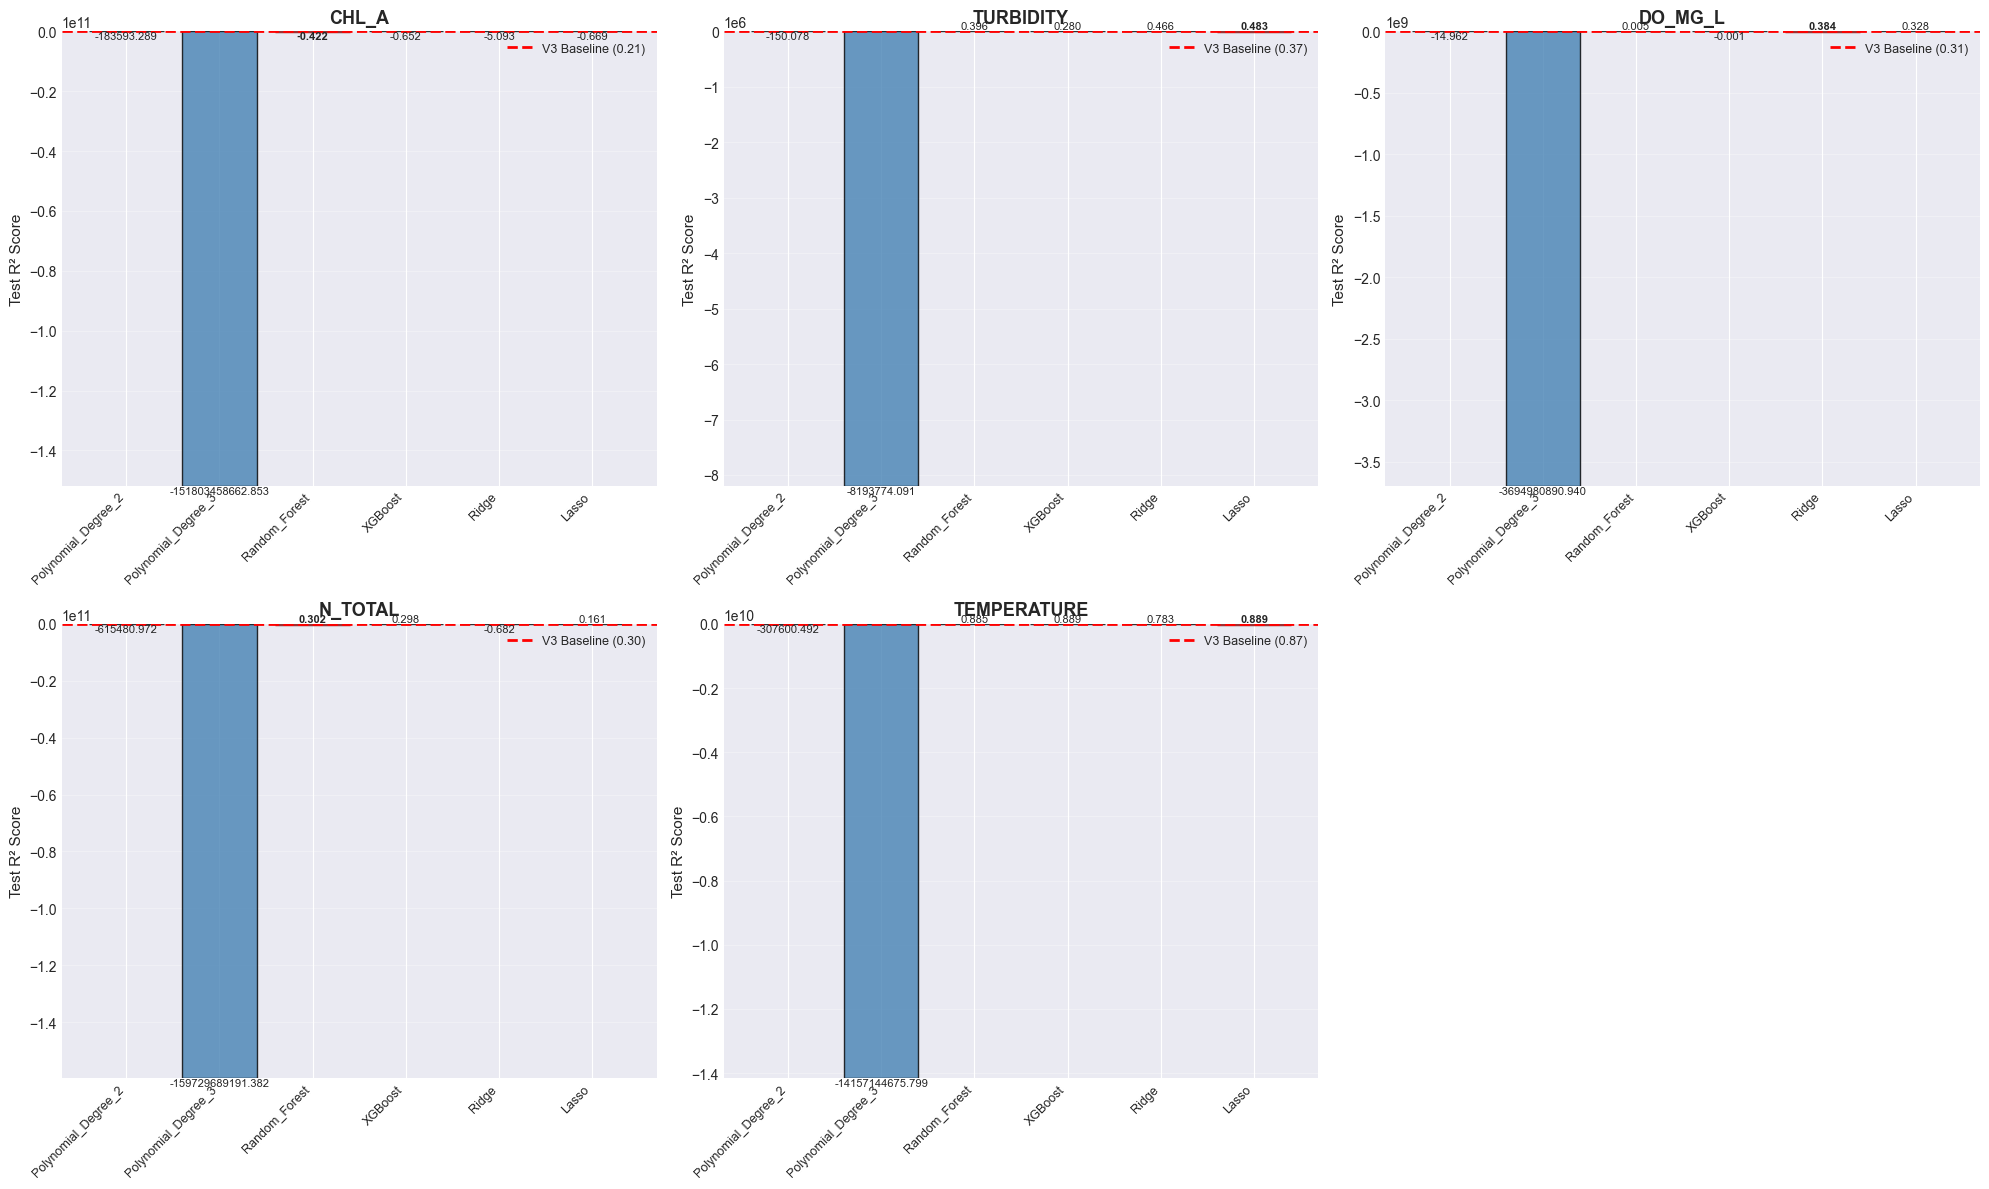

In [20]:
# Plot R² comparison for all models and all parameters
fig, axes = plt.subplots(2, 3, figsize=(20, 12))
axes = axes.flatten()

for idx, param in enumerate(TARGET_PARAMS):
    param_results = all_results[param]
    
    # Prepare data
    model_names = list(param_results.keys())
    test_r2_scores = [param_results[m]['test_r2'] for m in model_names]
    
    # Create bar plot
    bars = axes[idx].bar(range(len(model_names)), test_r2_scores, 
                         color='steelblue', edgecolor='black', alpha=0.8)
    
    # Highlight best model
    best_idx = np.argmax(test_r2_scores)
    bars[best_idx].set_color('gold')
    bars[best_idx].set_edgecolor('darkred')
    bars[best_idx].set_linewidth(2.5)
    
    # Add V3 baseline
    axes[idx].axhline(y=v3_baseline[param], color='red', linestyle='--', 
                     linewidth=2, label=f'V3 Baseline ({v3_baseline[param]:.2f})')
    
    axes[idx].set_xticks(range(len(model_names)))
    axes[idx].set_xticklabels(model_names, rotation=45, ha='right', fontsize=9)
    axes[idx].set_ylabel('Test R² Score', fontsize=11)
    axes[idx].set_title(f'{param.upper()}', fontsize=13, fontweight='bold')
    axes[idx].legend(loc='upper right', fontsize=9)
    axes[idx].grid(True, alpha=0.3, axis='y')
    axes[idx].set_ylim([min(0, min(test_r2_scores) - 0.1), max(test_r2_scores) + 0.1])
    
    # Add value labels on bars
    for i, (bar, score) in enumerate(zip(bars, test_r2_scores)):
        height = bar.get_height()
        axes[idx].text(bar.get_x() + bar.get_width()/2., height,
                      f'{score:.3f}',
                      ha='center', va='bottom' if height > 0 else 'top', 
                      fontsize=8, fontweight='bold' if i == best_idx else 'normal')

fig.delaxes(axes[5])
plt.tight_layout()
plt.show()

## 13. Visualization - Best Model Predictions vs Actual

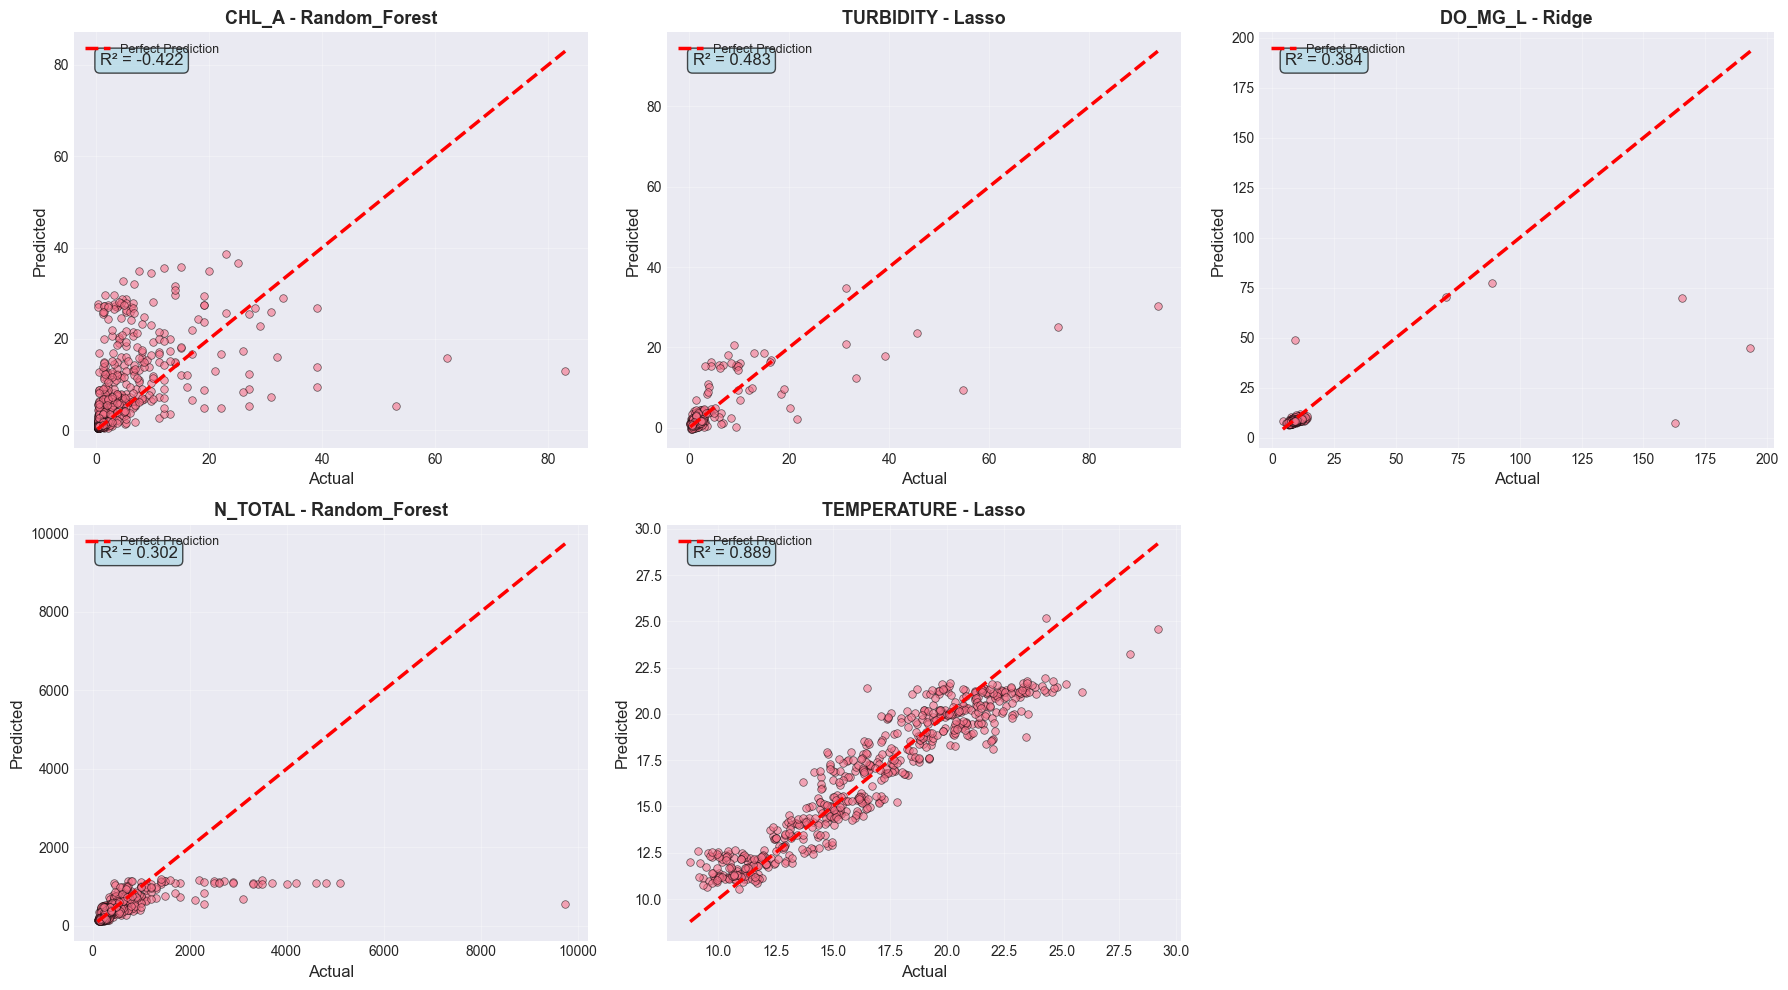

In [21]:
# Plot predictions vs actual for best model of each parameter
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

for idx, param in enumerate(TARGET_PARAMS):
    param_results = all_results[param]
    
    # Find best model
    best_model_name = max(param_results, key=lambda x: param_results[x]['test_r2'])
    best_result = param_results[best_model_name]
    
    y_test = best_result['y_test']
    y_pred = best_result['y_test_pred']
    r2 = best_result['test_r2']
    
    # Scatter plot
    axes[idx].scatter(y_test, y_pred, alpha=0.6, s=30, edgecolors='black', linewidth=0.5)
    axes[idx].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 
                   'r--', linewidth=2.5, label='Perfect Prediction')
    
    axes[idx].set_xlabel('Actual', fontsize=12)
    axes[idx].set_ylabel('Predicted', fontsize=12)
    axes[idx].set_title(f'{param.upper()} - {best_model_name}', fontsize=13, fontweight='bold')
    axes[idx].legend(loc='upper left', fontsize=9)
    axes[idx].grid(True, alpha=0.3)
    
    # Add R² annotation
    axes[idx].text(0.05, 0.95, f"R² = {r2:.3f}", 
                  transform=axes[idx].transAxes, 
                  fontsize=12, 
                  verticalalignment='top',
                  bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.7))

fig.delaxes(axes[5])
plt.tight_layout()
plt.show()

## 14. Visualization - V3 vs V5 Comparison

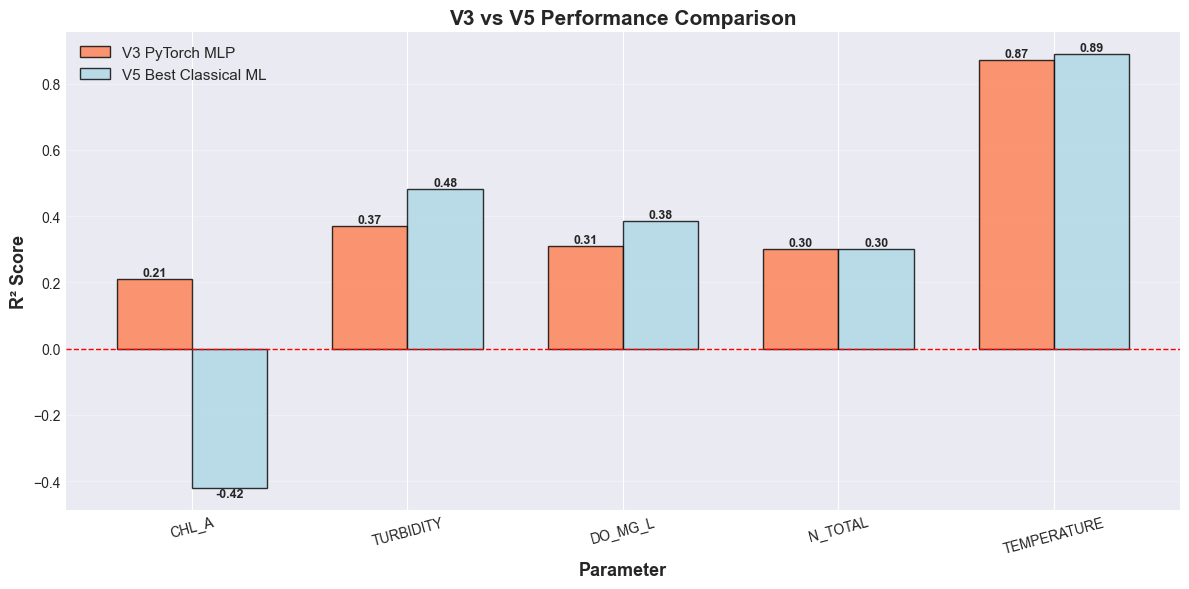

In [22]:
# Create comparison bar chart
fig, ax = plt.subplots(figsize=(12, 6))

x = np.arange(len(TARGET_PARAMS))
width = 0.35

v3_scores = [v3_baseline[p] for p in TARGET_PARAMS]
v5_scores = [max(all_results[p].values(), key=lambda x: x['test_r2'])['test_r2'] for p in TARGET_PARAMS]

bars1 = ax.bar(x - width/2, v3_scores, width, label='V3 PyTorch MLP', 
               color='coral', edgecolor='black', alpha=0.8)
bars2 = ax.bar(x + width/2, v5_scores, width, label='V5 Best Classical ML', 
               color='lightblue', edgecolor='black', alpha=0.8)

ax.set_xlabel('Parameter', fontsize=13, fontweight='bold')
ax.set_ylabel('R² Score', fontsize=13, fontweight='bold')
ax.set_title('V3 vs V5 Performance Comparison', fontsize=15, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels([p.upper() for p in TARGET_PARAMS], rotation=15)
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3, axis='y')
ax.axhline(y=0, color='red', linestyle='--', linewidth=1)

# Add value labels on bars
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.2f}',
                ha='center', va='bottom' if height > 0 else 'top', fontsize=9, fontweight='bold')

plt.tight_layout()
plt.show()

## 15. Feature Importance (for tree-based models)

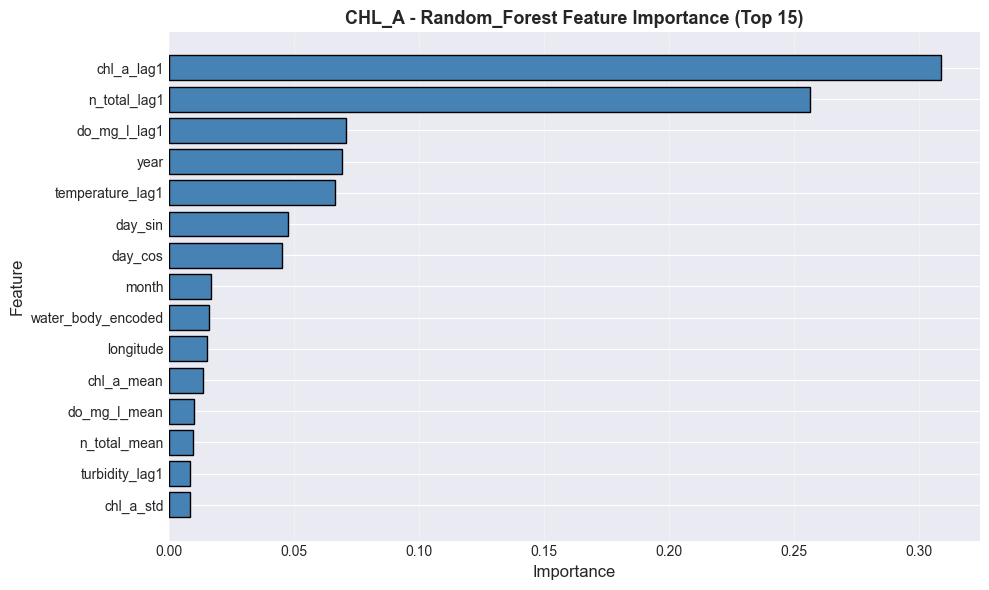

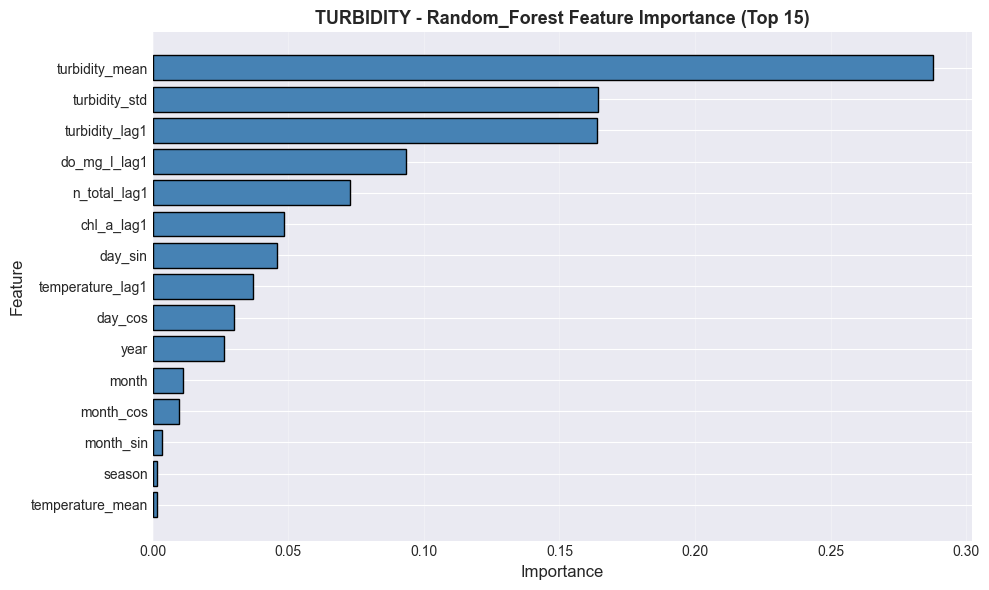

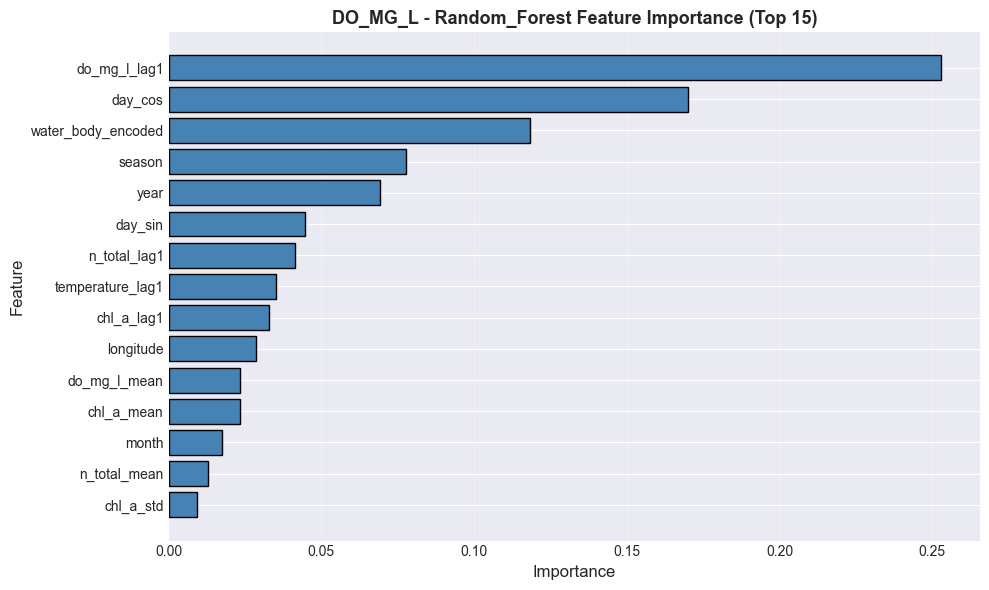

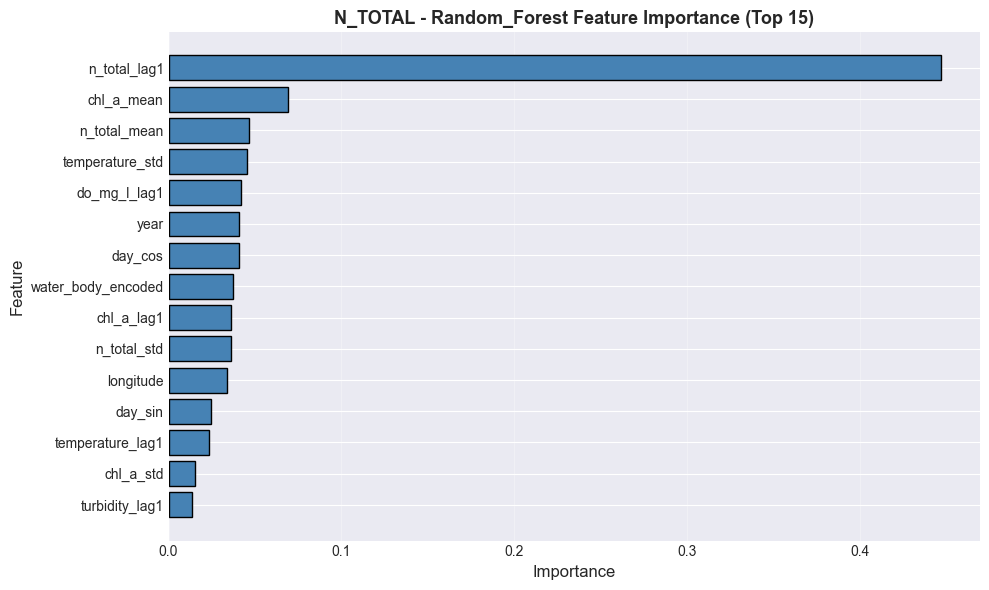

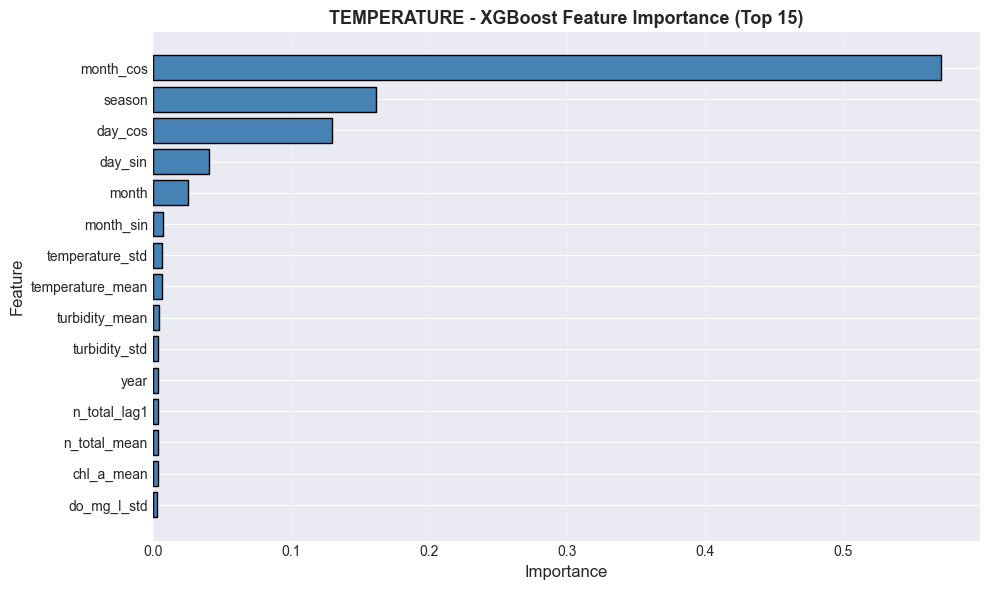

In [23]:
# Show feature importance for Random Forest and XGBoost
def plot_feature_importance(param_name, model_name, model, features, top_n=15):
    """
    Plot feature importance for tree-based models.
    """
    if model_name not in ['Random_Forest', 'XGBoost']:
        return
    
    # Get feature importance
    if hasattr(model, 'feature_importances_'):
        importances = model.feature_importances_
    else:
        return
    
    # Create dataframe
    importance_df = pd.DataFrame({
        'feature': features,
        'importance': importances
    }).sort_values('importance', ascending=False).head(top_n)
    
    # Plot
    plt.figure(figsize=(10, 6))
    plt.barh(range(len(importance_df)), importance_df['importance'], color='steelblue', edgecolor='black')
    plt.yticks(range(len(importance_df)), importance_df['feature'])
    plt.xlabel('Importance', fontsize=12)
    plt.ylabel('Feature', fontsize=12)
    plt.title(f'{param_name.upper()} - {model_name} Feature Importance (Top {top_n})', 
             fontsize=13, fontweight='bold')
    plt.gca().invert_yaxis()
    plt.grid(True, alpha=0.3, axis='x')
    plt.tight_layout()
    plt.show()

# Plot feature importance for best tree-based models
for param in TARGET_PARAMS:
    param_results = all_results[param]
    
    # Find best tree-based model
    tree_models = {k: v for k, v in param_results.items() if k in ['Random_Forest', 'XGBoost']}
    if tree_models:
        best_tree_model = max(tree_models, key=lambda x: tree_models[x]['test_r2'])
        plot_feature_importance(param, best_tree_model, 
                               param_results[best_tree_model]['model'], 
                               ALL_FEATURES)

## 16. Summary & Recommendations

In [24]:
print("\n" + "="*80)
print("SUMMARY - V5 CLASSICAL ML MODELS")
print("="*80)

print("\n✅ MODELS TESTED (6 models x 5 parameters = 30 models total):")
for model_name in get_ml_models().keys():
    print(f"  - {model_name}")

print("\n📊 BEST MODEL PER PARAMETER:")
for param in TARGET_PARAMS:
    param_results = all_results[param]
    best_model_name = max(param_results, key=lambda x: param_results[x]['test_r2'])
    best_r2 = param_results[best_model_name]['test_r2']
    v3_r2 = v3_baseline[param]
    improvement = best_r2 - v3_r2
    symbol = "📈" if improvement > 0 else "📉"
    print(f"  {symbol} {param.upper():15} - {best_model_name:25} (R²: {best_r2:.4f}, V3: {v3_r2:.4f}, Δ: {improvement:+.4f})")

print("\n🎯 OVERALL COMPARISON:")
avg_v3 = np.mean([v3_baseline[p] for p in TARGET_PARAMS])
avg_v5 = np.mean([max(all_results[p].values(), key=lambda x: x['test_r2'])['test_r2'] for p in TARGET_PARAMS])
overall_improvement = avg_v5 - avg_v3
print(f"  V3 Average R²:  {avg_v3:.4f}")
print(f"  V5 Average R²:  {avg_v5:.4f}")
print(f"  Improvement:    {overall_improvement:+.4f}")

if overall_improvement > 0:
    print("\n✅ V5 Classical ML models OUTPERFORM V3 PyTorch MLP on average!")
else:
    print("\n⚠️ V3 PyTorch MLP still performs better on average.")

print("\n🎯 NEXT STEPS:")
print("  1. Use best models from V5 for parameters where they outperform V3")
print("  2. Consider ensemble methods combining multiple models")
print("  3. Perform hyperparameter tuning on best-performing models")
print("  4. Try more advanced techniques (stacking, boosting)")
print("  5. Integrate best models with backend API for production")

print("\n" + "="*80)


SUMMARY - V5 CLASSICAL ML MODELS

✅ MODELS TESTED (6 models x 5 parameters = 30 models total):
  - Polynomial_Degree_2
  - Polynomial_Degree_3
  - Random_Forest
  - XGBoost
  - Ridge
  - Lasso

📊 BEST MODEL PER PARAMETER:
  📉 CHL_A           - Random_Forest             (R²: -0.4220, V3: 0.2100, Δ: -0.6320)
  📈 TURBIDITY       - Lasso                     (R²: 0.4831, V3: 0.3700, Δ: +0.1131)
  📈 DO_MG_L         - Ridge                     (R²: 0.3838, V3: 0.3100, Δ: +0.0738)
  📈 N_TOTAL         - Random_Forest             (R²: 0.3019, V3: 0.3000, Δ: +0.0019)
  📈 TEMPERATURE     - Lasso                     (R²: 0.8891, V3: 0.8700, Δ: +0.0191)

🎯 OVERALL COMPARISON:
  V3 Average R²:  0.4120
  V5 Average R²:  0.3272
  Improvement:    -0.0848

⚠️ V3 PyTorch MLP still performs better on average.

🎯 NEXT STEPS:
  1. Use best models from V5 for parameters where they outperform V3
  2. Consider ensemble methods combining multiple models
  3. Perform hyperparameter tuning on best-performing mode